In [20]:
import cvxpy as cp
from matplotlib import pyplot as plt
import sea2025
from part2_opf_helpers import clear_market, postprocess, make_graph, plot_graph

In [21]:
data = sea2025.data.read("data/pjm5bus")

In [22]:
result = clear_market(data)
print(f"Optimal dispatch cost: ${result.total_cost:.2f}/h")

Optimal dispatch cost: $17479.90/h


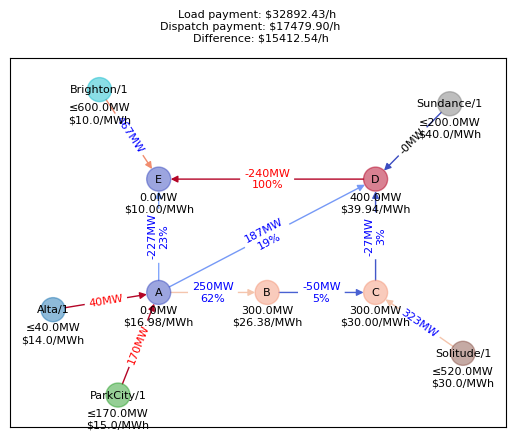

In [48]:
postprocess(result)
graph = make_graph(result)
fig, ax = plot_graph(graph, kscale=1.0, xscale=1.0, yscale=1.0)
plt.savefig("network.svg")
plt.show(block=False)

In [49]:
bus_residuals = sea2025.verification.bus_residuals(graph)
print(bus_residuals)

   bus   adjacency        flow
0    A      Alta/1   40.000000
1    A  ParkCity/1  170.000000
2    A           B -249.716765
3    A           D -186.788389
4    A           E  226.505154
5    A           A   -0.000000
6    B           A  249.716765
7    B           C   50.283235
8    B           B -300.000000
9    C           B  -50.283235
10   C  Solitude/1  323.494846
11   C           D   26.788389
12   C           C -300.000000
13   D           A  186.788389
14   D           C  -26.788389
15   D  Sundance/1   -0.000000
16   D           E  240.000000
17   D           D -400.000000
18   E           A -226.505154
19   E           D -240.000000
20   E  Brighton/1  466.505154
21   E           E   -0.000000


In [50]:
print(bus_residuals.groupby("bus").agg("sum"))

                adjacency          flow
bus                                    
A    Alta/1ParkCity/1BDEA  1.421085e-13
B                     ACB  0.000000e+00
C           BSolitude/1DC  0.000000e+00
D          ACSundance/1ED  0.000000e+00
E           ADBrighton/1E  0.000000e+00


In [51]:
cycle_edges = sea2025.verification.cycle_edges(graph)
print(cycle_edges)

     name from to        flow  reactance  delta_angle
0    ABCD    A  B  249.716765       2.81     7.017041
1    ABCD    B  C  -50.283235       1.08    -0.543059
2    ABCD    C  D  -26.788389       2.97    -0.795615
3    ABCD    A  D  186.788389       3.04    -5.678367
4   ABCDE    A  B  249.716765       2.81     7.017041
5   ABCDE    B  C  -50.283235       1.08    -0.543059
6   ABCDE    C  D  -26.788389       2.97    -0.795615
7   ABCDE    D  E -240.000000       2.97    -7.128000
8   ABCDE    A  E -226.505154       0.64     1.449633
9     DAE    A  D  186.788389       3.04    -5.678367
10    DAE    A  E -226.505154       0.64    -1.449633
11    DAE    D  E -240.000000       2.97     7.128000


In [52]:
print(cycle_edges.groupby("name").agg({"delta_angle": "sum"}))

        delta_angle
name               
ABCD  -8.881784e-16
ABCDE -1.110223e-15
DAE    0.000000e+00
